In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2022-11-18 20:45:07.680837: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-11-18 20:45:14.227303: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-11-18 20:45:14.263745: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-11-18 20:45:14.263793: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-11-18 20:45:14.266691: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-11-18 20:45:14.269446: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10

# Load Koch Meinhardt dataset


In [2]:
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_3/Koch_Meinhardt_3.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_3/simulation.txt")
with open(data_path, 'r') as f:
    simulation = eval(f.read()) 

t_star = np.linspace(simulation.t_start, simulation.t_end, simulation.t_steps)

#t_star = t_star[32*1::64]
#data = data[...,32*1::64]
t_star = t_star[32*6::64]
data = data[...,32*6::64]


T = t_star.shape[0]    
    
L = simulation.L[0]
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size

#alpha_u = 1/(np.max(data[0, ...]))
#alpha_v = 1/(np.max(data[1, ...]))
#alpha_u = 10
#alpha_v = 10

#data[0, ...] = data[0, ...]*alpha_u
#data[1, ...] = data[1, ...]*alpha_v

In [3]:
#t_star = np.concatenate([t_star, [10000]])
#T = t_star.shape[0] 
#data = np.concatenate([data, data[...,-1:]], axis=3)

In [4]:
data.shape

(2, 100, 100, 4)

In [5]:
t_star

array([192., 256., 320., 384.])

In [6]:
dxdy = x_size*y_size/L**2
diff_Y = np.array([[dxdy * simulation.Ds[c] *diffusion((x_size,y_size), data[c, ..., t]) 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
diff_Y = np.einsum("ctij -> cijt", diff_Y)

In [7]:
diff_Y.shape

(2, 100, 100, 4)

In [8]:
model_params = {'training_data_size': T*N//400,#T*32,
                'pde_data_size': (T*N)//400,#//(32),
                'boundary_data_size':((x_size + y_size)*T),
                'diffusion': diff_Y,
                'signal_to_noise':0.00,
                'shuffle':False}

dataset = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = np.concatenate([dataset['obs_input'], dataset['obs_output']], axis=1)
pde_X = dataset['pde']

pbc_X = np.concatenate([dataset['boundary_LB'], dataset['boundary_RT']], axis=1)

diffs = np.concatenate([dataset['diff_input'], dataset['diff_output']], axis=1)
diffs_point = np.concatenate([dataset['obs_input'], dataset['diff_output']], axis=1)
#diffs_point = dataset['diff_output']

In [9]:
pbc_X.shape

(800, 6)

In [10]:
ds4 = TINN_Dataset(tf.float32, obs_X, pde_X, pbc_X, diffs)
ds5 = TINN_Dataset(tf.float32, obs_X, pde_X, pbc_X, diffs, diffs_point)
ds6 = TINN_Dataset(tf.float32, obs_X,   diffs)
#ds = TINN_Dataset(tf.float32, obs_X, obs_Y, pde_X, pbc_X)
#ds4 = TINN_Dataset(tf.float32, obs_X, obs_Y, pde_X, diffs)

In [11]:
ds3 = TINN_Dataset(tf.float32, obs_X, pde_X,  pbc_X)

In [12]:
ds2 = TINN_Dataset(tf.float32, obs_X, pde_X)

In [13]:
ds1 = TINN_Dataset(tf.float32, obs_X)

In [14]:
print(ds1.sizes)
print(ds2.sizes)
print(ds3.sizes)
print(ds4.sizes)
print(ds5.sizes)
print(ds6.sizes)

[100]
[100 100]
[100 100 800]
[100 100 800 100]
[100 100 800 100 100]
[100 100]


In [15]:
#layers = [3, 1024, 1024, 1024, 1024, 2]
layers = [3, 512, 512, 512, 512, 512, 2]
pinnKM = tu.NN(layers, lb, ub, dtype=tf.float32)
pde_resKM = Koch_Meinhard(
                    D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, simulation.Ds[0], dtype=pinnKM.dtype),
                    D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT, simulation.Ds[1], dtype=pinnKM.dtype),
                    #kappa_u=PDE_Parameter("kappa_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype, zero_lb=True),
                    kappa_u=PDE_Parameter("kappa_u", Parameter_Type.CONSTANT, simulation.parameters["kappa_u"] ,dtype=pinnKM.dtype),
                    #mu_u=PDE_Parameter("mu_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    mu_u=PDE_Parameter("mu_u", Parameter_Type.CONSTANT, simulation.parameters["mu_u"],dtype=pinnKM.dtype),
                    rho_u=PDE_Parameter("rho_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    #rho_u=PDE_Parameter("rho_u", Parameter_Type.CONSTANT, simulation.parameters["rho_u"],dtype=pinnKM.dtype),                    
                    rho_v=PDE_Parameter("rho_v", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),                    
                    sigma_u=PDE_Parameter("sigma_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    #sigma_u=PDE_Parameter("sigma_u", Parameter_Type.CONSTANT, simulation.parameters["sigma_u"],dtype=pinnKM.dtype),
                    sigma_v=PDE_Parameter("sigma_v", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    #sigma_v=PDE_Parameter("sigma_v", Parameter_Type.CONSTANT, simulation.parameters["sigma_v"],dtype=pinnKM.dtype),
                   # alpha_u = alpha_u,
                   # alpha_v = alpha_v,
    regularise=True
    )
pbc_loss = Periodic_Boundary_Condition(regularise=False)
diff_loss_point = Diffusion_point_Loss(
                           Ds = simulation.Ds,
                           dtype = pinnKM.dtype)
diff_loss = Diffusion_Loss(ns = simulation.n,
                           Ls = simulation.L,
                           Ds = simulation.Ds,
                           dtype = pinnKM.dtype,
                           regularise=True,
                          )

obs_loss = Observation_Loss(regularise=True)

nzp_loss = Non_zero_params("Koch_Meinhard", [pde_resKM.sigma_u.tf_var, pde_resKM.sigma_v.tf_var])
nzp_loss2 = Non_zero_params("Koch_Meinhard", [pde_resKM.rho_u.tf_var, pde_resKM.rho_v.tf_var])

modelKM = tu.TINN(pinnKM, 
                  #losses= [obs_loss, pde_resKM, pbc_loss, diff_loss, diff_loss_point],                
               losses= [obs_loss, pde_resKM, pbc_loss, diff_loss], 
               #losses= [obs_loss, pde_resKM, pbc_loss], 
               #losses= [obs_loss, pde_resKM], 
               #losses= [obs_loss], 
                  norm = L2() + L_Inf(),
                  #no_input_losses=[nzp_loss, nzp_loss2],
                  alpha = 0.5, 
                  print_precision=".8f")

In [16]:
results_KM = modelKM.train(epochs = 100+1,
                          batch_size = 400,
                          dataset = ds5,
                          print_interval=10,
                          stop_threshold = -1,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=2)


Start of epoch 0


2022-11-18 20:46:57.086347: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-11-18 20:47:11.404584: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


Training observations acc over epoch: 0.00000000
total loss: 12736.12841415, total regularise loss: 6375.57910156
Observation_Loss ->  (1): 2.06432891  (2): 1.43023306 
Loss_Koch_Meinhard ->  (1): 2.02193153  (2): 1.99807817 
Periodic_Boundary_Condition ->  (1): 0.80118910 
Diffusion_Loss ->  (1): 3179.47365189 
lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 
lambdas (5): 1.00000000 
sigma_u: 0.99900 sigma_v: 0.99900 rho_u: 0.99917 rho_v: 1.00087 

Time taken: 31.77s

Start of epoch 10
Training observations acc over epoch: 0.00000000
total loss: 72.47639465, total regularise loss: 82.09906006
Observation_Loss ->  (1): 1.18568754  (2): 2.12874949 
Loss_Koch_Meinhard ->  (1): 1.06064993  (2): 1.96736228 
Periodic_Boundary_Condition ->  (1): 0.04136114 
Diffusion_Loss ->  (1): 14.90651274 
lambdas (1): 0.31852448 lambdas (2): 0.84743279 lambdas (3): 0.23746410 lambdas (4): 2.04726410 
lambdas (5): 1.54931462 
sigma_u: 0.99101 sigma_v: 0.988

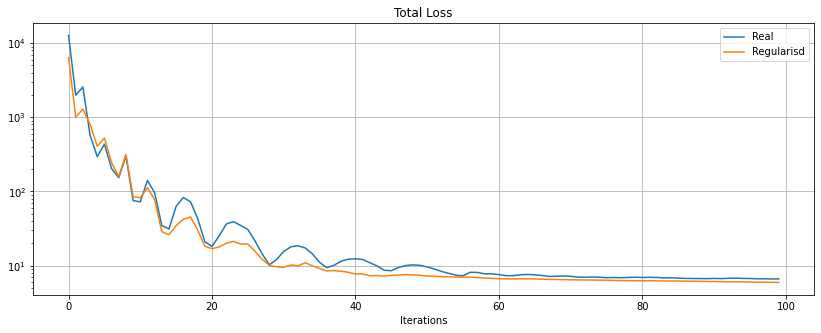

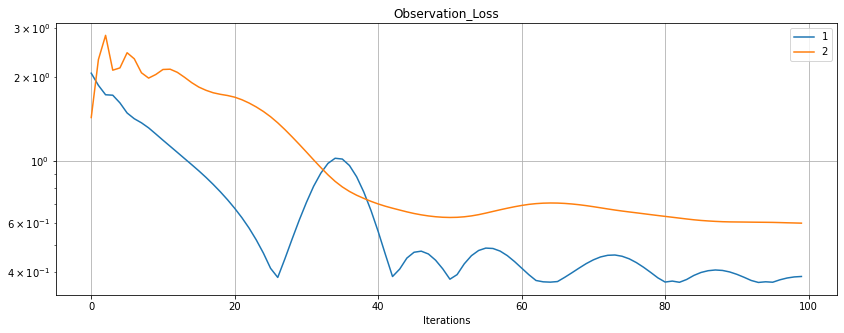

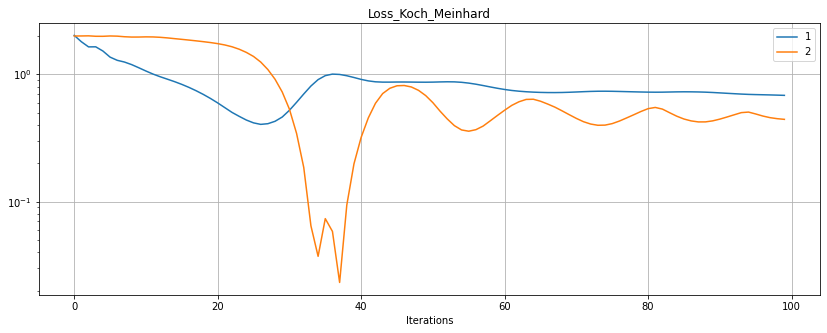

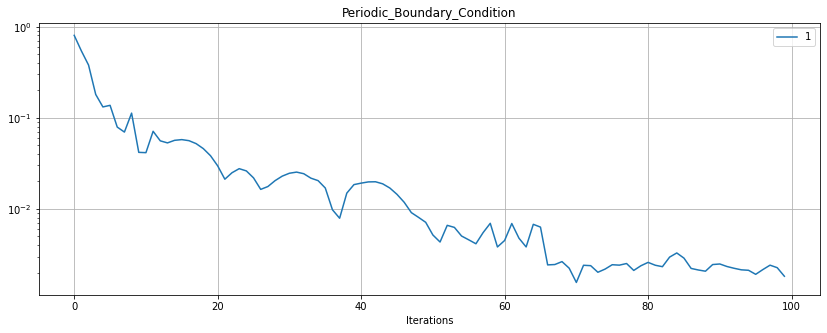

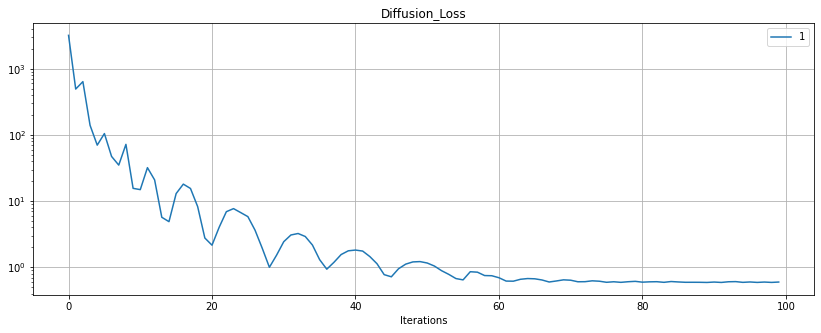

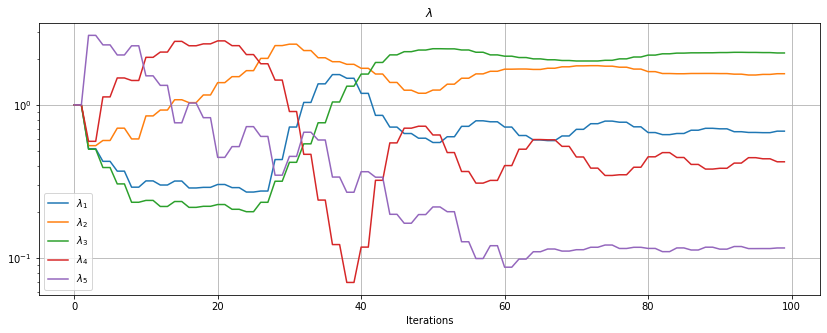

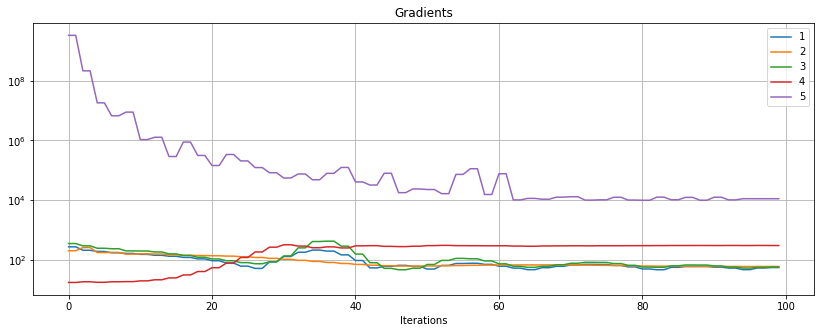

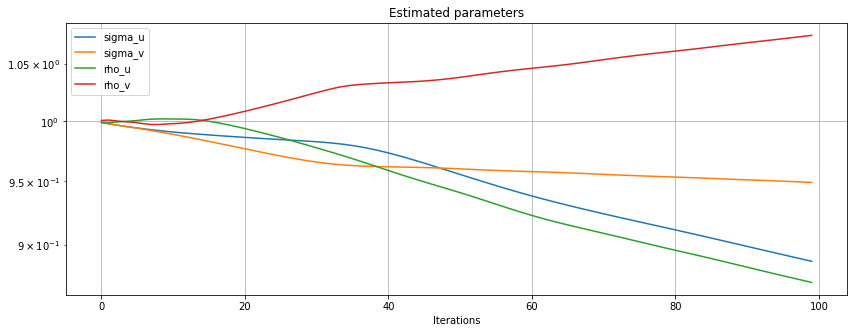

In [21]:
plot_result(merge_dict(results_KM), modelKM, start=0#, end=3000
            , param_names=["sigma_u","sigma_v", "rho_u", "rho_v"])

In [23]:
results_KM.keys()

dict_keys(['training_obs_accuracy', 'loss_total', 'loss_regularisd_total', 'Observation_Loss_values', 'Loss_Koch_Meinhard_values', 'Periodic_Boundary_Condition_values', 'Diffusion_Loss_values', 'lambdas', 'grads', 'sigma_u', 'sigma_v', 'rho_u', 'rho_v'])

In [20]:
def plot_result(
    results,
    model,
    param_names=None,
    start=0,
    end=-1,
    yscale="log",
    y_lims=None,
    figsize=(14, 5),
    file_name=None,
):
    import matplotlib.pyplot as plt

    def _closing_commands_(plot_name=""):
        plt.legend()
        plt.grid()
        plt.xlabel("Iterations")
        plt.yscale(yscale)
        if y_lims is not None:
            plt.ylim(y_lims)
        if file_name is not None:
            plt.savefig((f"{file_name}_{plot_name}.png"), bbox_inches="tight")
            plt.close()
        else:
            plt.show()

    #_ = plt.figure(figsize=figsize)
    #plt.title("Training accuracy for observations")
    #plt.plot(results["training_obs_accuracy"][start:end], label="accuracy")
    #_closing_commands_("training_accuracy")
    _ = plt.figure(figsize=figsize)
    plt.title("Total Loss")
    plt.plot(results["loss_total"][start:end], label="Real")
    plt.plot(results["loss_regularisd_total"][start:end], label="Regularisd")
    _closing_commands_("Total losses")

    for i, loss in enumerate(model.losses):
        _ = plt.figure(figsize=figsize)
        plt.title(loss.name)
        ts = results[f"{loss.name}_values"][start:end, :]
        for j in range(ts.shape[1]):
            plt.plot(ts[:,j], label=f"{j+1}")        
        _closing_commands_("Losses")

    for i, loss in enumerate(model.no_input_losses):
        _ = plt.figure(figsize=figsize)
        plt.title(loss.name)
        ts = results[f"{loss.name}_values"][start:end, :]
        for j in range(ts.shape[1]):
            plt.plot(ts[:,j], label=f"{j+1}")        
        _closing_commands_("No input losses")

    if "lambdas" in results.keys():
        _ = plt.figure(figsize=figsize)
        plt.title(r"$\lambda$")
        ts = results["lambdas"][start:end, :]
        for j in range(ts.shape[1]):
            plt.plot(ts[:,j], label=r"$\lambda_{" f"{j+1}" r"}$")          
        _closing_commands_("Lambdas")

    if "grads" in results.keys():
        _ = plt.figure(figsize=figsize)
        plt.title("Gradients")
        ts = results["grads"][start:end, :]
        for j in range(ts.shape[1]):
            plt.plot(ts[:,j], label=f"{j+1}")          
        _closing_commands_("Gradients")

    if param_names is not None:
        _ = plt.figure(figsize=figsize)
        plt.title(r"Estimated parameters")
        for name in param_names:
            plt.plot(results[f"{name}"][start:end], label=f"{name}")
        _closing_commands_("parameters")


In [19]:
modelKM.save(".", "test_model")

In [15]:
modelKM = tu.TINN.restore(".", "test_model", ds5)

2022-11-18 20:09:40.985125: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-11-18 20:09:43.093107: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


In [20]:
results_KM = modelKM.train(epochs = 30+1,
                          batch_size = 400,
                          dataset = ds5,
                          print_interval=1,
                          stop_threshold = -1,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=False,
                          regularise_interval=2)


Start of epoch 0
Training observations acc over epoch: 0.00000000
total loss: 7.91349602, total regularise loss: 5.76879454
Observation_Loss ->  (1): 0.38948655  (2): 0.29134433 
Loss_Koch_Meinhard ->  (1): 1.04608345  (2): 0.08513202 
Periodic_Boundary_Condition ->  (1): 0.00573581 
Diffusion_Loss ->  (1): 1.06661496 
lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 
lambdas (5): 1.00000000 
sigma_u: 0.90048 sigma_v: 0.92532 rho_u: 0.86719 rho_v: 1.11491 

Time taken: 0.23s

Start of epoch 1
Training observations acc over epoch: 0.00000000
total loss: 7.96187711, total regularise loss: 5.78596497
Observation_Loss ->  (1): 0.38748376  (2): 0.28324139 
Loss_Koch_Meinhard ->  (1): 1.04979646  (2): 0.08450456 
Periodic_Boundary_Condition ->  (1): 0.00917209 
Diffusion_Loss ->  (1): 1.07878399 
lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 
lambdas (5): 1.00000000 
sigma_u: 0.89938 sigma_v: 0.

Training observations acc over epoch: 0.00000000
total loss: 7.74625921, total regularise loss: 5.54888153
Observation_Loss ->  (1): 0.37496912  (2): 0.20775338 
Loss_Koch_Meinhard ->  (1): 1.07585472  (2): 0.01717449 
Periodic_Boundary_Condition ->  (1): 0.00684425 
Diffusion_Loss ->  (1): 1.09184480 
lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 
lambdas (5): 1.00000000 
sigma_u: 0.88300 sigma_v: 0.91520 rho_u: 0.84708 rho_v: 1.13094 

Time taken: 0.06s

Start of epoch 17
Training observations acc over epoch: 0.00000000
total loss: 7.74483013, total regularise loss: 5.55978489
Observation_Loss ->  (1): 0.37407227  (2): 0.20819359 
Loss_Koch_Meinhard ->  (1): 1.04909915  (2): 0.05600511 
Periodic_Boundary_Condition ->  (1): 0.00602183 
Diffusion_Loss ->  (1): 1.08650064 
lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 
lambdas (5): 1.00000000 
sigma_u: 0.88191 sigma_v: 0.91467 rho_u: 0.84

In [1]:
plot_result(merge_dict(results_KM), start=0#, end=3000
            , param_names=["sigma_u","sigma_v", "rho_u", "rho_v"])

NameError: name 'plot_result' is not defined

In [19]:
x_domain = simulation.L[0] * np.linspace(0, 1, simulation.n[0])
y_domain = simulation.L[1] * np.linspace(0, 1, simulation.n[1])
x_size = simulation.n[0]
y_size = simulation.n[1]
N2 = x_size * y_size


#T_test_index = -1#119
#T =224
index =3
#T = t_star[index]
#print(t_star[T_test_index])
T = 384.
print(T)
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N2 x 1
YY_test = Y_test.flatten()  # N2 x 1
TT_test = np.repeat(T, N2)  # 1 x N2
inputs = np.vstack([XX_test, YY_test, TT_test]).T

384.0


In [34]:
x_domain = simulation.L[0] * np.linspace(0, 1, simulation.n[0])
y_domain = simulation.L[1] * np.linspace(0, 1, simulation.n[1])
x_size = simulation.n[0]
y_size = simulation.n[1]
N2 = x_size * y_size


#T_test_index = -1#119
#T =224
index =2
#T = 384.
T = t_star[index]
#T = 3000
#print(t_star[T_test_index])
print(T)
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N2 x 1
YY_test = Y_test.flatten()  # N2 x 1
TT_test = np.repeat(T, N2)  # 1 x N2
inputs = np.vstack([XX_test, YY_test, TT_test]).T

320.0


In [35]:
output_test = pinnKM(np.vstack([XX_test, YY_test, TT_test]).T)
output_test = np.array([ output_test[:, i].numpy().reshape((x_size, y_size)) for i in range(output_test.shape[1])]) 

In [26]:
t_star

array([192., 256., 320., 384.])

In [36]:
test_d = np.vstack([XX_test, YY_test, TT_test]).T.astype(np.float32)
test_outputs = np.zeros((test_d.shape[0], 2))
test_pde_u = np.zeros(test_d.shape[0])
test_pde_v = np.zeros(test_d.shape[0])
outs, pde_u, pde_v = pde_resKM.residual(pinnKM, test_d)
test_outputs = np.array([test_outputs[..., i].reshape(x_size, y_size) for i in range(2)])
#test_outputs[i] = outs.numpy()
test_pde_u = pde_u.numpy().reshape(x_size, y_size)
test_pde_v = pde_v.numpy().reshape(x_size, y_size)

In [38]:
print(np.sqrt(np.mean((output_test[0, ...]-data[0,:,:, index])**2)))
print(np.sqrt(np.mean((output_test[1, ...]-data[1,:,:, index])**2)))
print(np.max(test_pde_u))
print(np.max(test_pde_v))
print(np.sqrt(np.mean(test_pde_u**2)))
print(np.sqrt(np.mean(test_pde_v**2)))

0.01801910366195771
0.1120325554024536
0.044896454
0.00061175064
0.01612387
0.00035053483


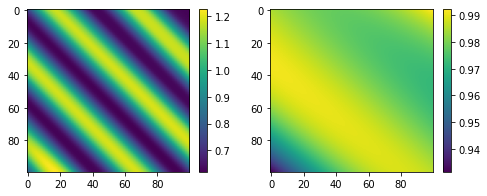

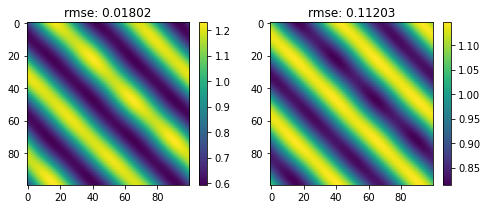

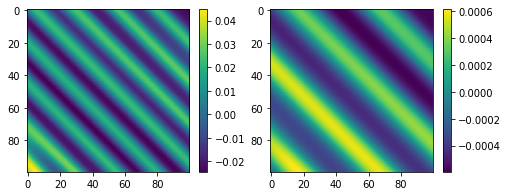

In [39]:

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(output_test[0, ...])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(output_test[1, ...])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
rmse = np.sqrt(np.mean( (output_test[0, ...]-data[0,:,:, index])**2 ))#/np.max(data[0,:,:, index])
plt.title(f"rmse: {rmse:.5f}")
plt.imshow(data[0,:,:, index])
plt.colorbar(shrink=.75)
plt.subplot(122)
rmse = np.sqrt(np.mean( (output_test[1, ...]-data[1,:,:, index])**2 ))#/np.max(data[1,:,:, index])
plt.title(f"rmse: {rmse:.5f}")
plt.imshow(data[1,:,:, index])
plt.colorbar(shrink=.75)
plt.show()

#index = 0
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(test_pde_u)
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(test_pde_v)
plt.colorbar(shrink=.75)
plt.show()

In [30]:
@tf.function
def derivatives(pinn, x):
    return pde_resKM.derivatives(pinn, x)

In [40]:
y, u, u_t, u_xx, u_yy, v, v_t, v_xx, v_yy = derivatives(pinnKM, test_d)
D_u = pde_resKM.D_u.get_value(test_d)
D_v = pde_resKM.D_v.get_value(test_d)
sigma_u = pde_resKM.sigma_u.get_value(test_d) / pde_resKM.alpha_u
sigma_v = pde_resKM.sigma_v.get_value(test_d) / pde_resKM.alpha_v
mu_u = pde_resKM.mu_u.get_value(test_d)
rho_u = pde_resKM.rho_u.get_value(test_d) * pde_resKM.alpha_u * pde_resKM.alpha_v
rho_v = pde_resKM.rho_v.get_value(test_d) * pde_resKM.alpha_u * pde_resKM.alpha_u
kappa_u = pde_resKM.kappa_u.get_value(test_d) * pde_resKM.alpha_u * pde_resKM.alpha_u

In [24]:
D_v

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [41]:
diffusion_u = D_u * (u_xx + u_yy)
diffusion_v = D_v * (v_xx + v_yy)

dxdy = np.prod(simulation.n)/np.prod(simulation.L)
diffusion_u_space = D_u * dxdy * diffusion(simulation.n, u.numpy().reshape(x_size, y_size))
diffusion_v_space = D_v * dxdy * diffusion(simulation.n, v.numpy().reshape(x_size, y_size))


f = u * u * v / (1.0 + kappa_u * u * u)
non_lin_u = -rho_u * f
non_lin_v = rho_v * f
f_u = - rho_u * f + mu_u * u - sigma_u
f_v = rho_v * f - sigma_v
d_t_u = - D_u * (u_xx + u_yy) - rho_u * f + mu_u * u - sigma_u
d_t_v = -D_v * (v_xx + v_yy) + rho_v * f - sigma_v



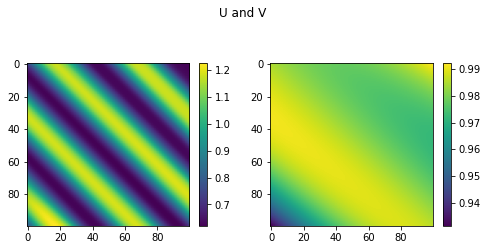

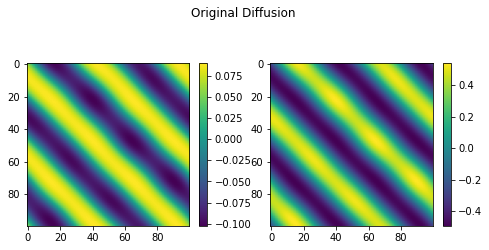

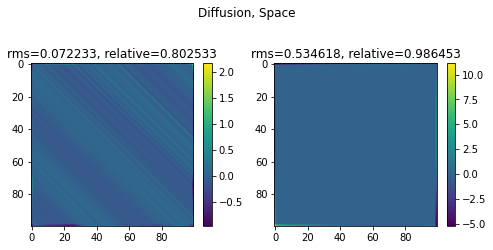

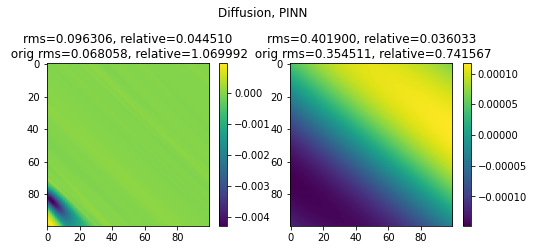

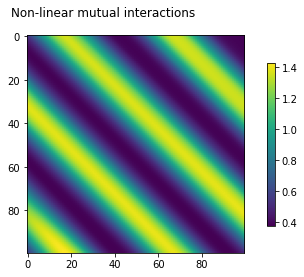

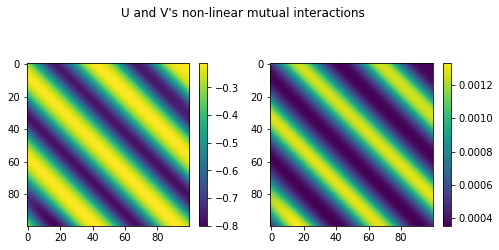

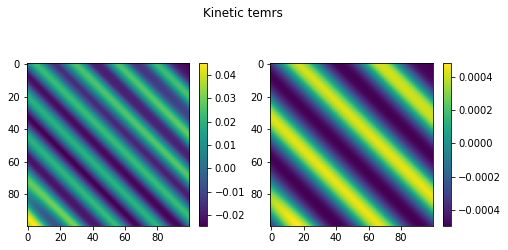

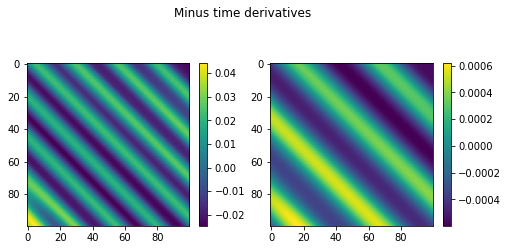

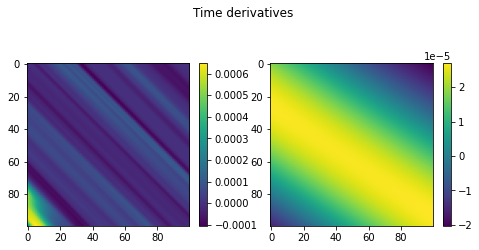

In [42]:
#index = 0
_ = plt.figure(figsize=(8,4))
plt.suptitle("U and V")
plt.subplot(121)
plt.imshow(u.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(v.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.suptitle("Original Diffusion")
plt.subplot(121)
plt.imshow(diff_Y[0, :, :, index])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(diff_Y[1, :, :, index])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.suptitle("Diffusion, Space")
plt.subplot(121)
rms = np.sqrt(np.mean((diff_Y[0, :, :, index]-diffusion_u_space)**2))
relative_rms = rms/np.max(diff_Y[0, :, :, index])
plt.title(f"rms={rms:.6f}, relative={relative_rms:.6f}")
plt.imshow(diffusion_u_space)
plt.colorbar(shrink=.75)
plt.subplot(122)
rms = np.sqrt(np.mean((diff_Y[1, :, :, index]-diffusion_v_space)**2))
relative_rms = rms/np.max(diff_Y[1, :, :, index])
plt.title(f"rms={rms:.6f}, relative={relative_rms:.6f}")
plt.imshow(diffusion_v_space)
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.suptitle("Diffusion, PINN")
plt.subplot(121)
rms = np.sqrt(np.mean((diffusion_u.numpy().reshape(x_size, y_size)-diffusion_u_space)**2))
relative_rms = rms/np.max(diffusion_u_space)
rms2 = np.sqrt(np.mean((diff_Y[0, :, :, index]-diffusion_u.numpy().reshape(x_size, y_size))**2))
relative_rms2 = rms/np.max(diff_Y[0, :, :, index])
plt.title(f"rms={rms:.6f}, relative={relative_rms:.6f}\n orig rms={rms2:.6f}, relative={relative_rms2:.6f}")
plt.imshow(diffusion_u.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.subplot(122)
rms = np.sqrt(np.mean((diffusion_v.numpy().reshape(x_size, y_size)-diffusion_v_space)**2))
relative_rms = rms/np.max(diffusion_v_space)
rms2 = np.sqrt(np.mean((diff_Y[1, :, :, index]-diffusion_v.numpy().reshape(x_size, y_size))**2))
relative_rms2 = rms/np.max(diff_Y[1, :, :, index])
plt.title(f"rms={rms:.6f}, relative={relative_rms:.6f}\n orig rms={rms2:.6f}, relative={relative_rms2:.6f}")
plt.imshow(diffusion_v.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()



_ = plt.figure(figsize=(8,4))
plt.suptitle("Non-linear mutual interactions")
plt.imshow(f.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.suptitle("U and V's non-linear mutual interactions")
plt.subplot(121)
plt.imshow(non_lin_u.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(non_lin_v.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.suptitle("Kinetic temrs")
plt.subplot(121)
plt.imshow(f_u.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(f_v.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.suptitle("Minus time derivatives")
plt.subplot(121)
plt.imshow(d_t_u.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(d_t_v.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.suptitle("Time derivatives")
plt.subplot(121)
plt.imshow(u_t.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(v_t.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()